In [1]:
import numpy as np
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import sys

import argparse, os, math, pickle, json

# 1) Load your model
from dual_alm_rnn_models import *
from dual_alm_rnn_exp import DualALMRNNExp



Get the readout accuracies per side

one seed:


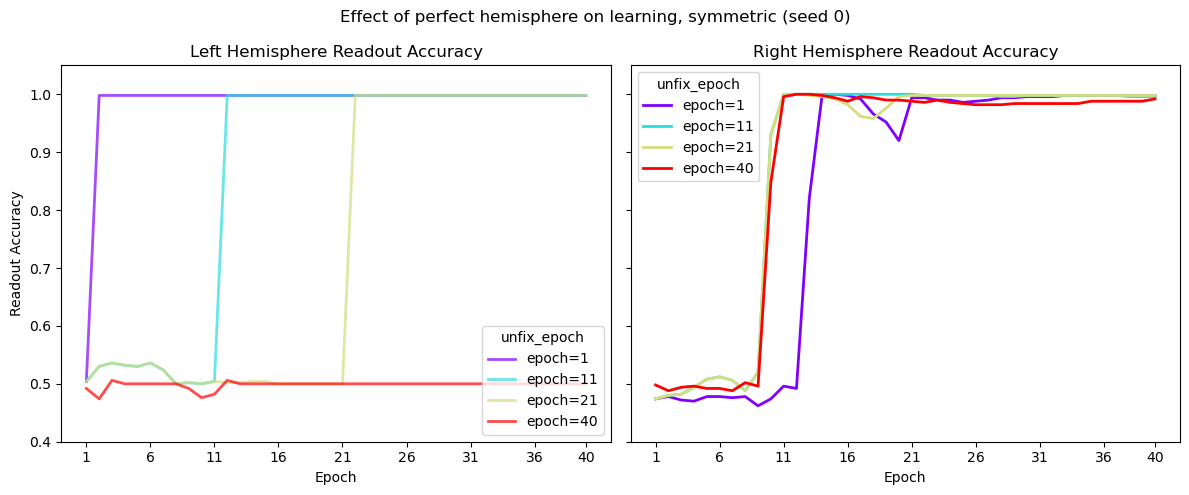

In [86]:
exp = DualALMRNNExp()
all_readout_acc_right = []
all_readout_acc_left = []
unfix_epochs = [0, 10, 20, 30, 40]
random_seed = 0
unfix_epochs = [1,11,21,40]
# unfix_epochs = ['11_1p5', '11']

# For color mapping: use a colormap for right hemisphere lines
import matplotlib
cmap = plt.get_cmap('Blues')
cmap = plt.get_cmap('rainbow')
colors = [cmap(i/(len(unfix_epochs)-1)) for i in range(len(unfix_epochs))]

for unfix_epoch in unfix_epochs:
    if 'asymmetric_fix' in exp.configs['train_type']:
        results_dict = np.load(
            'dual_alm_rnn_logs/{}/{}/n_neurons_4_random_seed_{}/unfix_epoch_{}/n_epochs_40_n_epochs_across_hemi_0/lr_3.0e-03_bs_75/sigma_input_noise_0.10_sigma_rec_noise_0.10/xs_left_alm_amp_{:.2f}_right_alm_amp_{:.2f}/init_cross_hemi_rel_factor_0.20/all_val_results_dict.npy'.format(
                exp.configs['model_type'],
                exp.configs['train_type'],
                # exp.configs['random_seed'],
                random_seed,
                unfix_epoch,
                float(exp.configs['xs_left_alm_amp']),
                float(exp.configs['xs_right_alm_amp'])),
            allow_pickle=True
        )

    epochs = np.arange(1, len(results_dict) + 1)
    readout_acc_left = np.array([results_dict[i]['control']['readout_accuracy_left'] for i in range(len(results_dict))])
    readout_acc_right = np.array([results_dict[i]['control']['readout_accuracy_right'] for i in range(len(results_dict))])

    all_readout_acc_left.append(readout_acc_left)
    all_readout_acc_right.append(readout_acc_right)

# Set xticks every 5 epochs (e.g., 1, 5, 10, 15, ...)
max_epoch = epochs[-1]
xticks = np.arange(1, max_epoch+1, 5)
if xticks[-1] != max_epoch:
    xticks = np.append(xticks, max_epoch)

# Plot: two subplots, left and right hemisphere accuracy, right with color/legend for unfix_epoch
fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Left hemisphere subplot
for i, unfix_epoch in enumerate(unfix_epochs):
    label = f'epoch={unfix_epoch}'
    ax_left.plot(epochs, all_readout_acc_left[i], color=colors[i], label=label, alpha=0.7, linewidth=2)
ax_left.set_title('Left Hemisphere Readout Accuracy')
ax_left.set_xlabel('Epoch')
ax_left.set_ylabel('Readout Accuracy')
ax_left.set_xticks(xticks)
ax_left.set_ylim(0.4, 1.05)
ax_left.legend(title='unfix_epoch', loc='lower right')

# Right hemisphere subplot
for i, unfix_epoch in enumerate(unfix_epochs):
    label = f'epoch={unfix_epoch}'
    ax_right.plot(epochs, all_readout_acc_right[i], color=colors[i], label=label, linewidth=2)
ax_right.set_title('Right Hemisphere Readout Accuracy')
ax_right.set_xlabel('Epoch')
ax_right.set_xticks(xticks)
ax_right.set_ylim(0.4, 1.05)
ax_right.legend(title='unfix_epoch', loc='upper left')
plt.suptitle('Effect of perfect hemisphere on learning, symmetric (seed {})'.format(random_seed))
plt.tight_layout()
plt.show()

All seeds as subplots

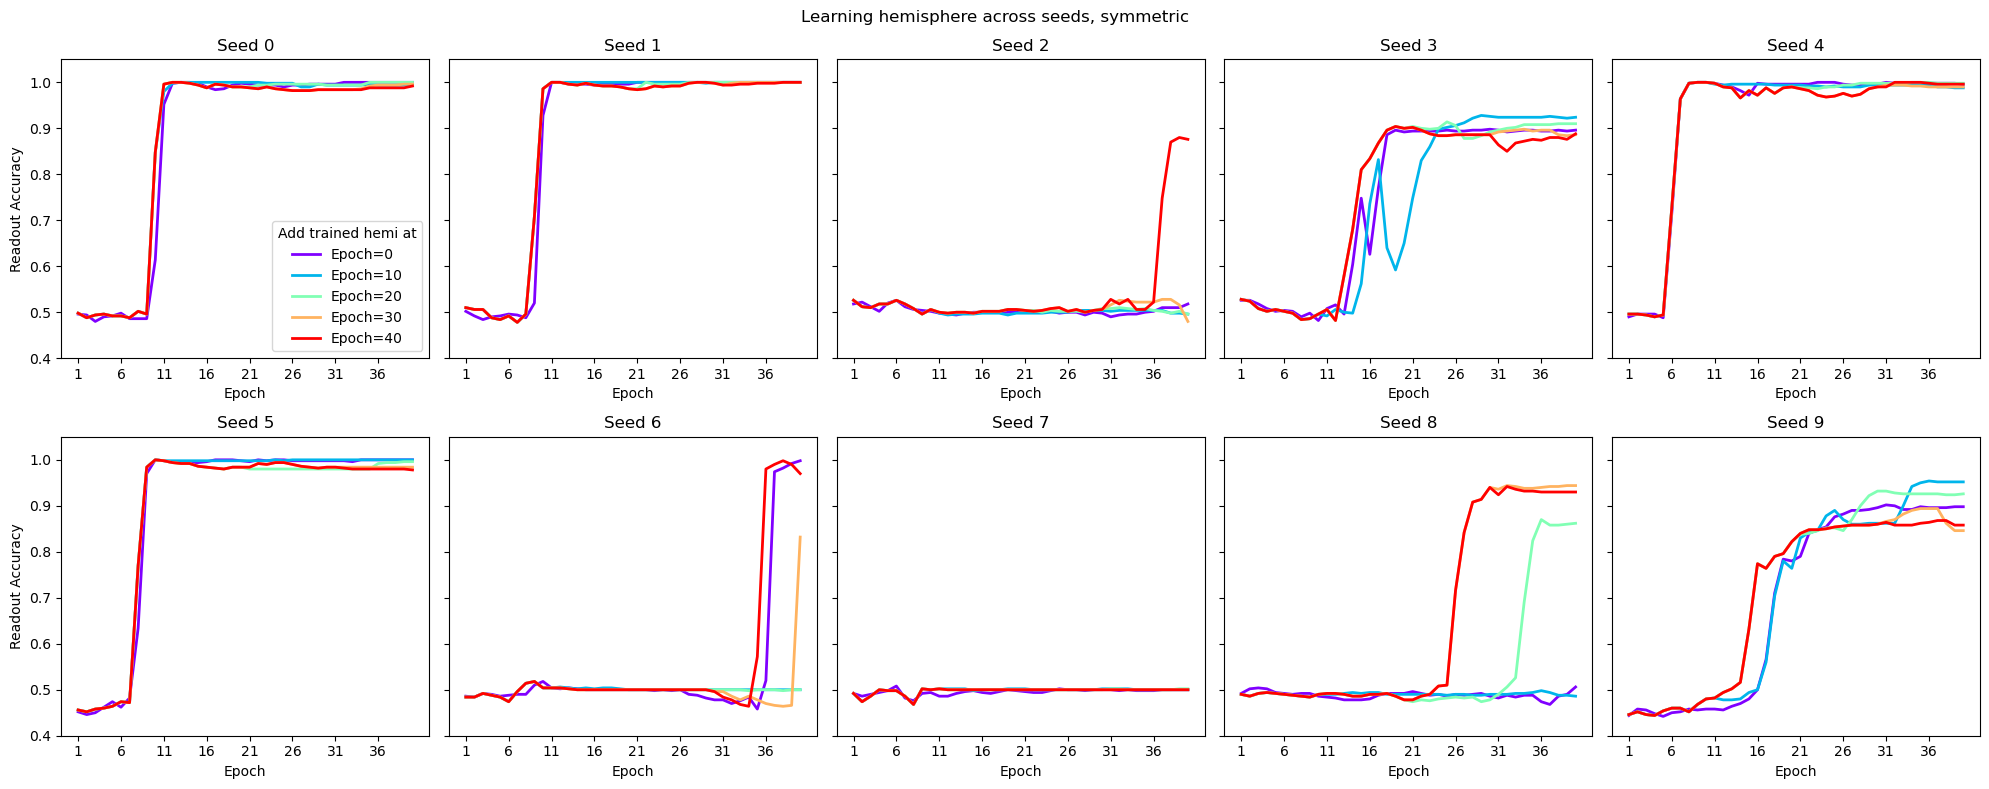

In [33]:
# Iterate over all 10 random seeds and plot overlays per unfix_epoch regime

unfix_epochs = [0, 10, 20, 30, 40]
# unfix_epochs = [0,20,40]
num_seeds = 10

import matplotlib
# Use a rainbow colormap for each unfix_epoch
cmap = plt.get_cmap('rainbow')
colors = [cmap(i/(len(unfix_epochs)-1)) for i in range(len(unfix_epochs))]

# Store all runs for plotting
all_readout_acc_left = [[]
                        for _ in range(len(unfix_epochs))]
all_readout_acc_right = [[]
                         for _ in range(len(unfix_epochs))]

for seed in range(num_seeds):
    exp = DualALMRNNExp()
    exp.configs['random_seed'] = seed  # override seed for this run

    for i, unfix_epoch in enumerate(unfix_epochs):
        if 'asymmetric_fix' in exp.configs['train_type']:
            results_dict = np.load(
                'dual_alm_rnn_logs/{}/{}/n_neurons_4_random_seed_{}/unfix_epoch_{}/n_epochs_40_n_epochs_across_hemi_0/lr_3.0e-03_bs_75/sigma_input_noise_0.10_sigma_rec_noise_0.10/xs_left_alm_amp_{:.2f}_right_alm_amp_{:.2f}/init_cross_hemi_rel_factor_0.20/all_val_results_dict.npy'.format(
                    exp.configs['model_type'],
                    exp.configs['train_type'],
                    seed,
                    unfix_epoch,
                    float(exp.configs['xs_left_alm_amp']),
                    float(exp.configs['xs_right_alm_amp'])),
                allow_pickle=True
            )

        epochs = np.arange(1, len(results_dict) + 1)
        readout_acc_left = np.array([results_dict[i]['control']['readout_accuracy_left'] for i in range(len(results_dict))])
        readout_acc_right = np.array([results_dict[i]['control']['readout_accuracy_right'] for i in range(len(results_dict))])

        all_readout_acc_left[i].append(readout_acc_left)
        all_readout_acc_right[i].append(readout_acc_right)

# Plot: 10 subplots (2 rows x 5 columns), one for each seed, plotting right hemisphere readout accuracy for all unfix_epochs
fig, axes = plt.subplots(2, 5, figsize=(20, 8), sharey=True)
axes = axes.flatten()

for seed in range(num_seeds):
    ax = axes[seed]
    for i, unfix_epoch in enumerate(unfix_epochs):
        # Plot right hemisphere accuracy for this seed and unfix_epoch
        ax.plot(epochs, all_readout_acc_right[i][seed], color=colors[i], label=f'unfix_epoch={unfix_epoch}' if seed == 0 else None, linewidth=2)
    ax.set_title(f'Seed {seed}')
    ax.set_xlabel('Epoch')
    if seed % 5 == 0:
        ax.set_ylabel('Readout Accuracy')
    ax.set_xticks(epochs[::5])
    ax.set_ylim(0.4, 1.05)

# Only add legend to the first subplot
handles = [matplotlib.lines.Line2D([0], [0], color=colors[i], lw=2) for i in range(len(unfix_epochs))]
labels = [f'Epoch={unfix_epochs[i]}' for i in range(len(unfix_epochs))]
axes[0].legend(handles, labels, title='Add trained hemi at', loc='lower right')

plt.suptitle('Learning hemisphere across seeds, symmetric')
plt.tight_layout()
plt.show()

All seeds overlay:


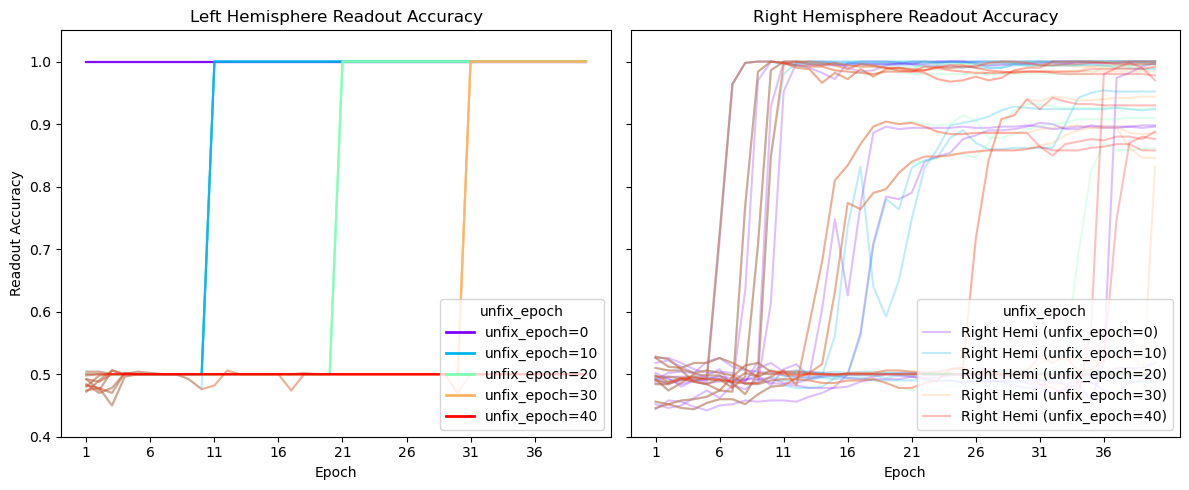

In [8]:
# Iterate over all 10 random seeds and plot overlays per unfix_epoch regime

unfix_epochs = [0, 10, 20, 30, 40]
num_seeds = 10

import matplotlib
# Use a rainbow colormap for each unfix_epoch
cmap = plt.get_cmap('rainbow')
colors = [cmap(i/(len(unfix_epochs)-1)) for i in range(len(unfix_epochs))]

# Store all runs for plotting
all_readout_acc_left = [[]
                        for _ in range(len(unfix_epochs))]
all_readout_acc_right = [[]
                         for _ in range(len(unfix_epochs))]

for seed in range(num_seeds):
    exp = DualALMRNNExp()
    exp.configs['random_seed'] = seed  # override seed for this run

    for i, unfix_epoch in enumerate(unfix_epochs):
        if 'asymmetric_fix' in exp.configs['train_type']:
            results_dict = np.load(
                'dual_alm_rnn_logs/{}/{}/n_neurons_4_random_seed_{}/unfix_epoch_{}/n_epochs_40_n_epochs_across_hemi_0/lr_3.0e-03_bs_75/sigma_input_noise_0.10_sigma_rec_noise_0.10/xs_left_alm_amp_{:.2f}_right_alm_amp_{:.2f}/init_cross_hemi_rel_factor_0.20/all_val_results_dict.npy'.format(
                    exp.configs['model_type'],
                    exp.configs['train_type'],
                    seed,
                    unfix_epoch,
                    float(exp.configs['xs_left_alm_amp']),
                    float(exp.configs['xs_right_alm_amp'])),
                allow_pickle=True
            )

        epochs = np.arange(1, len(results_dict) + 1)
        readout_acc_left = np.array([results_dict[i]['control']['readout_accuracy_left'] for i in range(len(results_dict))])
        readout_acc_right = np.array([results_dict[i]['control']['readout_accuracy_right'] for i in range(len(results_dict))])

        all_readout_acc_left[i].append(readout_acc_left)
        all_readout_acc_right[i].append(readout_acc_right)

# Plot: two subplots, left and right hemisphere accuracy, overlaying all 10 runs per unfix_epoch
fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Left hemisphere subplot: overlay all seeds for each unfix_epoch, color-coded by unfix_epoch (rainbow)
for i, unfix_epoch in enumerate(unfix_epochs):
    for run in range(num_seeds):
        ax_left.plot(epochs, all_readout_acc_left[i][run], color=colors[i], alpha=0.25)
ax_left.set_title('Left Hemisphere Readout Accuracy')
ax_left.set_xlabel('Epoch')
ax_left.set_ylabel('Readout Accuracy')
ax_left.set_xticks(epochs[::5])
ax_left.set_ylim(0.4, 1.05)
# Add legend for each unfix_epoch (rainbow colors)
handles_left = [matplotlib.lines.Line2D([0], [0], color=colors[i], lw=2) for i in range(len(unfix_epochs))]
labels_left = [f'unfix_epoch={unfix_epochs[i]}' for i in range(len(unfix_epochs))]
ax_left.legend(handles_left, labels_left, title='unfix_epoch', loc='lower right')

# Right hemisphere subplot: overlay all seeds for each unfix_epoch, color-coded by unfix_epoch (rainbow)
for i, unfix_epoch in enumerate(unfix_epochs):
    for run in range(num_seeds):
        label = f'Right Hemi (unfix_epoch={unfix_epoch})' if run == 0 else None
        ax_right.plot(epochs, all_readout_acc_right[i][run], color=colors[i], alpha=0.25, label=label)
# Add legend only once per unfix_epoch
handles, labels = ax_right.get_legend_handles_labels()
unique_labels = []
unique_handles = []
for h, l in zip(handles, labels):
    if l not in unique_labels and l is not None:
        unique_labels.append(l)
        unique_handles.append(h)
ax_right.set_title('Right Hemisphere Readout Accuracy')
ax_right.set_xlabel('Epoch')
ax_right.set_xticks(epochs[::5])
ax_right.set_ylim(0.4, 1.05)
ax_right.legend(unique_handles, unique_labels, title='unfix_epoch', loc='lower right')

plt.tight_layout()
plt.show()

Analyze over different asymmetries

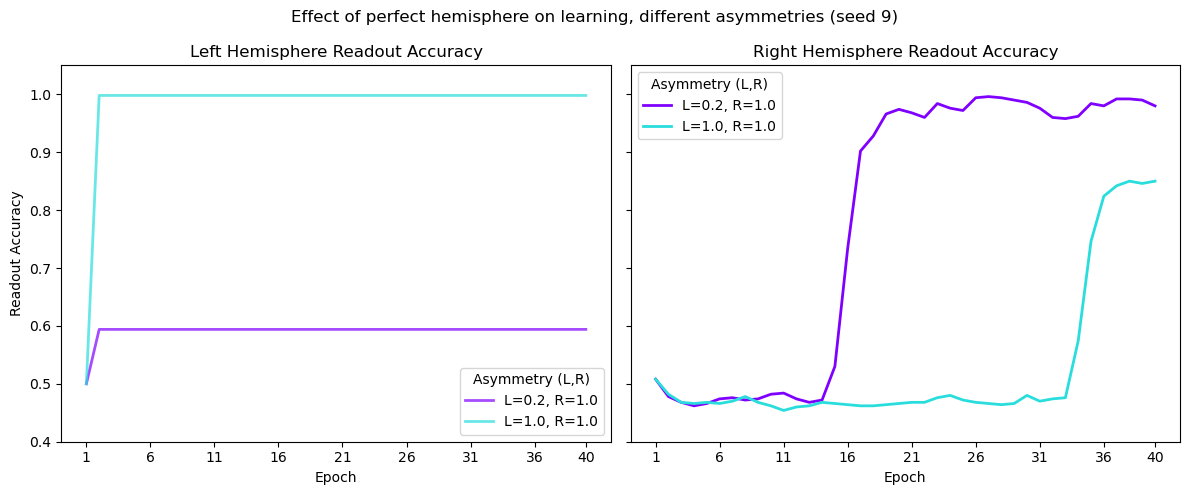

In [91]:
exp = DualALMRNNExp()
all_readout_acc_right = []
all_readout_acc_left = []
unfix_epochs = [0, 10, 20, 30, 40]

random_seed = 9
unfix_epochs = [1,11,21,40]
unfix_epoch = 1
asymmetries = [(0.2,1.0),(1.0,1.0)]

# For color mapping: use a colormap for right hemisphere lines

cmap = plt.get_cmap('Blues')
cmap = plt.get_cmap('rainbow')
colors = [cmap(i/(len(unfix_epochs)-1)) for i in range(len(unfix_epochs))]

# Iterate over asymmetries instead of unfix_epochs
all_readout_acc_right = []
all_readout_acc_left = []
asymmetry_labels = []
for i, (left_alm_amp, right_alm_amp) in enumerate(asymmetries):
    if 'asymmetric_fix' in exp.configs['train_type']:
        results_dict = np.load(
            'dual_alm_rnn_logs/{}/{}/n_neurons_4_random_seed_{}/unfix_epoch_{}/n_epochs_40_n_epochs_across_hemi_0/lr_3.0e-03_bs_75/sigma_input_noise_0.10_sigma_rec_noise_0.10/xs_left_alm_amp_{:.2f}_right_alm_amp_{:.2f}/init_cross_hemi_rel_factor_0.20/all_val_results_dict.npy'.format(
                exp.configs['model_type'],
                exp.configs['train_type'],
                # exp.configs['random_seed'],
                random_seed,
                unfix_epoch,
                left_alm_amp,
                right_alm_amp),
            allow_pickle=True
        )

    epochs = np.arange(1, len(results_dict) + 1)
    readout_acc_left = np.array([results_dict[i]['control']['readout_accuracy_left'] for i in range(len(results_dict))])
    readout_acc_right = np.array([results_dict[i]['control']['readout_accuracy_right'] for i in range(len(results_dict))])

    all_readout_acc_left.append(readout_acc_left)
    all_readout_acc_right.append(readout_acc_right)
    asymmetry_labels.append(f"L={left_alm_amp:.1f}, R={right_alm_amp:.1f}")

# Set xticks every 5 epochs (e.g., 1, 5, 10, 15, ...)
max_epoch = epochs[-1]
xticks = np.arange(1, max_epoch+1, 5)
if xticks[-1] != max_epoch:
    xticks = np.append(xticks, max_epoch)

# Plot: two subplots, left and right hemisphere accuracy, colored/legend by asymmetry
fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Left hemisphere subplot
for i, label in enumerate(asymmetry_labels):
    ax_left.plot(epochs, all_readout_acc_left[i], color=colors[i], label=label, alpha=0.7, linewidth=2)
ax_left.set_title('Left Hemisphere Readout Accuracy')
ax_left.set_xlabel('Epoch')
ax_left.set_ylabel('Readout Accuracy')
ax_left.set_xticks(xticks)
ax_left.set_ylim(0.4, 1.05)
ax_left.legend(title='Asymmetry (L,R)', loc='lower right')

# Right hemisphere subplot
for i, label in enumerate(asymmetry_labels):
    ax_right.plot(epochs, all_readout_acc_right[i], color=colors[i], label=label, linewidth=2)
ax_right.set_title('Right Hemisphere Readout Accuracy')
ax_right.set_xlabel('Epoch')
ax_right.set_xticks(xticks)
ax_right.set_ylim(0.4, 1.05)
ax_right.legend(title='Asymmetry (L,R)', loc='upper left')
plt.suptitle('Effect of perfect hemisphere on learning, different asymmetries (seed {})'.format(random_seed))

plt.tight_layout()
plt.show()

In [ ]:
# quick script to get init conditions for taiga



Get the model


In [6]:
exp = DualALMRNNExp()

# Load configs to get model parameters
with open('dual_alm_rnn_configs.json', 'r') as f:
    configs = json.load(f)

model = getattr(sys.modules[__name__], configs['model_type'])(configs, \
    exp.a, exp.pert_begin, exp.pert_end, noise=True)
# model = TwoHemiRNNTanh_single_readout(configs, exp.a, exp.pert_begin, exp.pert_end)
exp.init_sub_path(configs['train_type'])

checkpoint_file = 'model_epoch_9.pth'
checkpoint_path = os.path.join(configs['models_dir'], configs['model_type'], exp.sub_path, checkpoint_file)
if not os.path.exists(checkpoint_path):
    raise FileNotFoundError(f"Model checkpoint not found at {checkpoint_path}")
print(checkpoint_path)
state_dict = torch.load(checkpoint_path, map_location='cpu', weights_only=True)
model.load_state_dict(state_dict)
# params = {'batch_size': configs['bs'], 'shuffle': True}
# inputs = data.TensorDataset(torch.tensor(sensory_inputs), torch.tensor(trial_type_labels))
# inputs = data.DataLoader(inputs, **params)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") # CW Mac update
model = model.to(device)

# Draw the readout trajectory
bias = model.readout_linear.bias.data.cpu().numpy()[0]
readout_weights = model.readout_linear.weight.data.cpu().numpy()
recurrent_weights = model.rnn_cell.w_hh_linear_ll.weight.data.cpu().numpy()


# model.rnn_cell.w_hh_linear_ll.weight.data = torch.tensor([
#     [1.5, -0.3],
#     [-0.3, 1.5]], dtype=torch.float32).to(device)
# model.rnn_cell.w_hh_linear_ll.bias.data = torch.tensor([0.0, 0.0], dtype=torch.float32).to(device)
# model.w_xh_linear_left_alm.weight.data = torch.tensor([
#     [1.0, 0.0],
#     [0.0, 1.0]
# ], dtype=torch.float32).to(device)

# model.readout_linear.weight.data = torch.tensor([
#     [1.0, -1.0, 0.0, 0.0]
# ], dtype=torch.float32).to(device)
# model.w_xh_linear_left_alm.bias.data = torch.tensor([0.0, 0.0], dtype=torch.float32).to(device)
# print(bias, readout_weights, recurrent_weights)


Fixed input weights for left and right ALM
dual_alm_rnn_models/TwoHemiRNNTanh_single_readout/train_type_asymmetric_fixed_input/n_neurons_4_random_seed_4/unfix_epoch_10/n_epochs_40_n_epochs_across_hemi_0/lr_3.0e-03_bs_75/sigma_input_noise_0.10_sigma_rec_noise_0.10/xs_left_alm_amp_1.00_right_alm_amp_1.00/init_cross_hemi_rel_factor_0.20/model_epoch_9.pth
